# Demo : Why the add-small-constant objective preserves the same optimal parameters


We'd like to train a (linear) classifier on a dataset.

We want this classifier to achieve some desired precision $\alpha$ (set in the `alpha = ____` line below).

We wish to compare 2 different objectives for solving this problem:

* the ideal objective

\begin{align}
\min_w - &tpc(w)
\\
\text{subj. to.}~~ - &tpc(w) + \frac{\alpha}{1-\alpha} fpc(w) \leq 0
\end{align}

* the *correct* add-small-constant objective

\begin{align}
\min_w - &tpc_{\varepsilon}(w)
\\
\text{subj. to.}~~ - &tpc_{\varepsilon}(w) + \frac{\alpha}{1-\alpha} fpc(w) + \underbrace{N_+ \varepsilon}_{\text{corrected}} \leq 0
\end{align}


where we define a vertically-shifted true-positive count

$$
tpc_{\varepsilon}(w) = \sum_{n : y_n = 1} z_{\varepsilon}( f_w(x_n) ) = tpc(w) + N_+ \varepsilon
$$

based on a vertically-shifted zero-one loss

\begin{align}
z_{\varepsilon}( r ) = \begin{cases}
    1 + \varepsilon & \text{if}~ r \geq 0
    \\
    \varepsilon     & \text{if}~ r > 0
\end{cases}
\end{align}

### Plan of attack

* We'll show empirically that the ideal and add-small-const objectives have the same optimal weights w^*
* We'll also show that an add-small-const objective WITHOUT the key correction term has a different optima (and may not satisfy the desired precision $\alpha$)

### Setup

In [1]:
import os
import sys
import time
import itertools

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize

In [3]:
import autograd
import autograd.numpy as ag_np

from autograd.scipy.special import expit as ag_logistic_sigmoid

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

In [5]:
# Custom visualization routines
import visuals

# Wrappers around scipy.optimize solvers
import solvers

# Utility functions to compute true TP/FP/TN/FN and predict score for each example
from binary_clf_utils import calc_binary_clf_perf, calc_decision_score

In [6]:
# Load toydata generating module
import toydata

In [7]:
# Load modeling modules
import BCE
import SurrogateSigmoid
import SurrogateHinge

In [8]:
figsize = (5, 5)

## Create Toy Data

Features:
* 2 dimensions, drawn from Gaussian blobs

Labels:
* binary task, so 0 or 1
* positive label is rare

In [9]:
x_ND, y_N, x_pos_ND, y_pos_N, x_neg_ND, y_neg_N = toydata.create_toy_dataset()

In [10]:
N = x_ND.shape[0]
Npos = x_pos_ND.shape[0]
Nneg = x_neg_ND.shape[0]

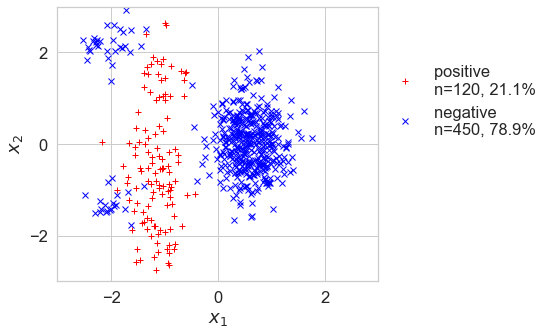

In [11]:
f, axs = plt.subplots(1, 1, figsize=(8,5))
axs.plot(x_pos_ND[:,0], x_pos_ND[:,1], 'r+', label='positive \nn=%2d, %.1f%%' % (Npos, 100*Npos/N))
axs.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'bx', label='negative \nn=%2d, %.1f%%' % (Nneg, 100*Nneg/N))
axs.set_xlim([-3, 3]); axs.set_xticks([-2, 0, 2]);
axs.set_ylim([-3, 3]); axs.set_yticks([-2, 0, 2]);
axs.legend(
    loc='lower left',
    bbox_to_anchor= (1.01, 0.5),
    borderaxespad=0,
    frameon=False);
axs.set_xlabel(r'$x_1$')
axs.set_ylabel(r'$x_2$')

plt.tight_layout()
f.savefig(os.path.join('images', 'toy_example.png'))

### Specify Precision Constraint

In [12]:
alpha = 0.9      # precision to enforce

### Define ideal loss function

In [13]:
def calc_loss_ideal(w_D):
    u_N = calc_decision_score(x_ND, w_D)
    yhat_N = np.asarray(u_N >= 0, dtype=np.int32)
    perf = calc_binary_clf_perf(y_N, yhat_N)
    
    f = -1 * perf['TP']
    g = -1 * perf['TP'] + alpha/(1-alpha) * perf['FP']
    return (f
        + 100000 * np.maximum(0.0, g) 
        + (np.inf if perf['recall'] < 0.0001 else 0.0) # avoid degenerate solutions with no recall
        ), perf['recall'], perf['precision']

### Define the add-small-constant loss function

we'll explore the *corrected* and uncorrected versions

In [14]:
def calc_loss_addsmallconstant_nocorrection(w_D, eps=0.1):
    Npos = np.sum(y_N == 1)
    
    u_N = calc_decision_score(x_ND, w_D)
    yhat_N = np.asarray(u_N >= 0, dtype=np.int32)
    perf = calc_binary_clf_perf(y_N, yhat_N)
    
    f = -1 * (perf['TP'] + Npos * eps)
    g = -1 * (perf['TP'] + Npos * eps) + alpha/(1-alpha) * perf['FP'] #+ Npos * eps
    return (f
        + 100000 * np.maximum(0.0, g) 
        + (np.inf if perf['recall'] < 0.0001 else 0.0) # avoid degenerate solutions with no recall
        ), perf['recall'], perf['precision']

In [15]:
def calc_loss_addsmallconstant_corrected(w_D, eps=0.1):
    Npos = np.sum(y_N == 1)
    
    u_N = calc_decision_score(x_ND, w_D)
    yhat_N = np.asarray(u_N >= 0, dtype=np.int32)
    perf = calc_binary_clf_perf(y_N, yhat_N)
    
    f = -1 * (perf['TP'] + Npos * eps)
    g = -1 * (perf['TP'] + Npos * eps) + alpha/(1-alpha) * perf['FP'] + Npos * eps
    return (f
        + 100000 * np.maximum(0.0, g) 
        + (np.inf if perf['recall'] < 0.0001 else 0.0) # avoid degenerate solutions with no recall
        ), perf['recall'], perf['precision']

### Define utility methods for performing an exhaustive grid search over all w_D vectors

In [16]:
def calc_w_D_that_creates_boundary_at_h_theta(h, theta):
    ''' Solve for 3-dim vector w_D creating desired boundary
    
    We use two parameters to define all possible lines in a rectangular area
    One defines the y-intercept of the line
    The other defines the angle the line makes with x-axis
    
    Given these parameters, this function solves for the weights w_D
    that parameterize the linear decision boundary indicated
    
    Args
    ----
    h : float
        Y-intercept of the line
    theta : float
        Angle (in radians) of the line
    
    Returns
    -------
    w_D : 1D array, size D=3
        Weight parameters of the vector, in (wx, wy, b) form
    '''
    w2 = np.sqrt(1.0 / (1 + h**2 + np.tan(theta)**2))
    w1 = - np.tan(theta) * w2
    b = -w2 * h
    
    sign = 2 * (np.floor(theta / np.pi) % 2) - 1
    
    w_D = sign * np.hstack([w1, w2, b])
    assert np.all(np.isfinite(w_D))
    try:
        assert np.allclose(np.sum(np.square(w_D)), 1.0, atol=1e-5)
    except Exception:
        print(theta)
        print(h)
        print(w_D)
    return w_D

In [17]:
def find_toy_solution_via_grid_search(
        calc_loss_func,
        n_angle_grid_points=360, n_offset_grid_points=101,
        B=9.0):
    '''
    Search a fine grid of linear boundaries, parameterized by
    * the angle of the line from horizontal, a scalar from 0-360 deg
    * the offset, a scalar from -B to +B
    '''
    
    G = n_angle_grid_points
    theta_G = np.linspace(0.0, 2 * np.pi - 1e-6, G)
    
    H = n_offset_grid_points
    offsets_H = np.linspace(-B, B, H)
    
    best_cost = np.inf
    best_gg = 0
    best_hh = 0
    
    cost_GH = np.inf + np.zeros((G, H))
    for gg, theta in enumerate(theta_G):
        for hh, offset in enumerate(offsets_H):
            w_D = calc_w_D_that_creates_boundary_at_h_theta(offset, theta)
            
            try:
                cost_GH[gg, hh], rec, prec = calc_loss_func(w_D)
            except Exception as e:
                print(w_D)
                raise e
            if cost_GH[gg, hh] < best_cost:
                best_cost = cost_GH[gg,hh]
                best_gg = gg
                best_hh = hh
                best_w_D = w_D
    
    bcost, brec, bprec = calc_loss_func(best_w_D)

    return best_w_D, best_cost, dict(cost_GH=cost_GH, offsets_H=offsets_H, theta_G=theta_G, best_recall=brec, best_precision=bprec)

### Visual demo of the grid search

(-5.0, 5.0)

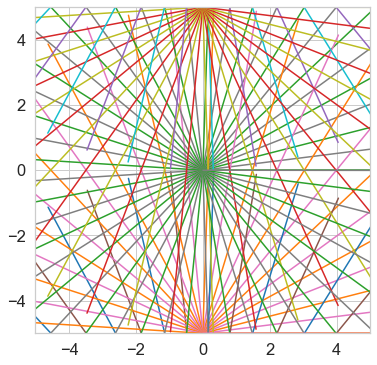

In [18]:
plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for theta in np.linspace(0, 2*np.pi-0.001, 50):
    for h in np.linspace(-10, 10, 5):

        a_D = np.asarray([0.0, h])
        b_D = np.asarray([10*np.cos(theta), 10*np.sin(theta) + h])

        xy_ND = np.vstack([a_D, b_D])
        plt.plot(xy_ND[:,0], xy_ND[:,1], '-')

        #assert np.allclose(1.0, np.sqrt(np.sum(np.square(a_D - b_D))))
plt.xlim([-5, 5]);
plt.ylim([-5, 5])

### Sanity check: boundary with h = -2.0, theta = 0.0

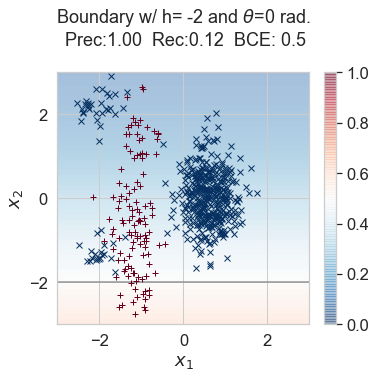

In [19]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    calc_w_D_that_creates_boundary_at_h_theta(-2.0, 0.0),
    x_ND, y_N,
    title_str=r'Boundary w/ h= -2 and $\theta$=0 rad.',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

### Sanity check: boundary with h = -2.0, theta = $\pi$

Note, this is a *180-deg rotation of the previous picture above.*

We had to be careful to make sure that the w_D created by our mapping from h,theta had the right sign in this case

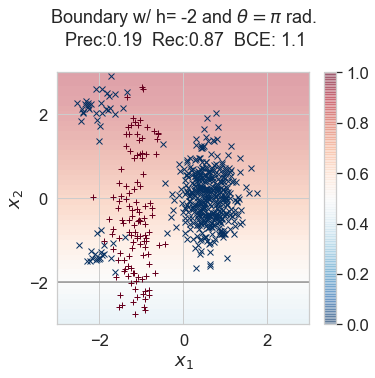

In [20]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    calc_w_D_that_creates_boundary_at_h_theta(-2.0, np.pi),
    x_ND, y_N,
    title_str=r'Boundary w/ h= -2 and $\theta=\pi$ rad.',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

## Grid search

We'll perform grid search for all 3 objectives

In [21]:
n_angle_grid_points=301
n_offset_grid_points=201
B = 5.0

In [22]:
ideal_wstar_D, ideal_cost, info = find_toy_solution_via_grid_search(
    calc_loss_ideal,
    n_angle_grid_points=n_angle_grid_points,
    n_offset_grid_points=n_offset_grid_points,
    B=B)

In [23]:
addsmallcorrect_wstar_D, addsmallcorrect_cost, info = find_toy_solution_via_grid_search(
    calc_loss_addsmallconstant_corrected,
    n_angle_grid_points=n_angle_grid_points,
    n_offset_grid_points=n_offset_grid_points,
    B=B)

In [24]:
addsmall_nocorrection_wstar_D, addsmallcorrect_cost, info = find_toy_solution_via_grid_search(
    calc_loss_addsmallconstant_nocorrection,
    n_angle_grid_points=n_angle_grid_points,
    n_offset_grid_points=n_offset_grid_points,
    B=B)

In [25]:
ideal_wstar_D

array([-0.02220832, -0.52986822, -0.84778916])

In [26]:
addsmallcorrect_wstar_D

array([-0.02220832, -0.52986822, -0.84778916])

In [27]:
addsmall_nocorrection_wstar_D

array([ 0.        , -0.54212687, -0.84029665])

### Verify the *correct* add-small-constant objective has same optimal theta 

In [28]:
assert np.allclose(ideal_wstar_D, addsmallcorrect_wstar_D)

### Verify the *NOT-corrected* add-small-constant objective yields a different answer

In [29]:
assert not np.allclose(ideal_wstar_D, addsmall_nocorrection_wstar_D)

# Visualize boundaries from all 3 objectives

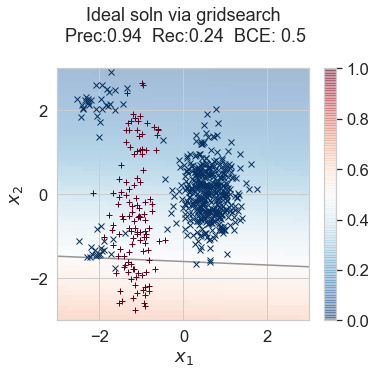

In [30]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    ideal_wstar_D, x_ND, y_N,
    title_str='Ideal soln via gridsearch',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

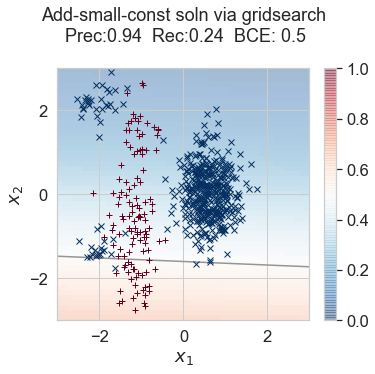

In [31]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    addsmallcorrect_wstar_D, x_ND, y_N,
    title_str='Add-small-const soln via gridsearch',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

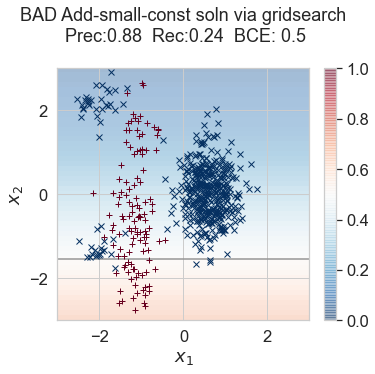

In [32]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    addsmall_nocorrection_wstar_D, x_ND, y_N,
    title_str='BAD Add-small-const soln via gridsearch',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);